* [Forecasting with Structural AR Timeseries](https://www.pymc.io/projects/examples/en/latest/time_series/Forecasting_with_structural_timeseries.html)
* [Bayesian Vector Autoregressive Models](https://www.pymc.io/projects/examples/en/latest/time_series/bayesian_var_model.html)
* [Sampling](https://www.pymc.io/projects/examples/en/latest/introductory/api_quickstart.html#sampling)

<br>

# Preliminaries

In [ ]:
import os

In [ ]:
os.chdir(path=os.getcwd())

In [ ]:
os.getcwd()

'/content'

<br>

## Libraries

In [ ]:
import time

import numpy as np
import pandas as pd

import arviz
import pymc

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

In [ ]:
import json
import urllib.request

In [ ]:
import statsmodels.graphics.tsaplots as sgt
import statsmodels.api as sa
import statsmodels.tsa.seasonal as stsl
import statsmodels.tsa.stattools as stst

<br>

## Settings

In [ ]:
RANDOM_SEED = 5
rng = np.random.default_rng(RANDOM_SEED)

<br>

## Graphing

In [ ]:
matplotlib.rcParams.update({'font.size': 13})
matplotlib.rcParams['text.usetex'] = False

sns.set(font_scale=1)
sns.set_style('dark')

plt.rcParams['figure.constrained_layout.use'] = False

<br>

## Logging

```python
logging.basicConfig(level=logging.INFO,
                    format='%\n(message)s\n%(asctime)s.%(msecs)03d',
                    datefmt='%Y-%m-%d %H:%M:%S', force=True, encoding='utf-8')
logger = logging.getLogger(__name__)
```

<br>
<br>

# Data

## Classes

In [ ]:
"""Module api.py"""

class API:
    """
    Notes<br>
    ------<br>

    For reading data sets from Scottish Health & Social Care <a href="https://www.opendata.nhs.scot" target="_blank">
    Open Data Platform</a>
    """

    def __init__(self):
        pass

    @staticmethod
    def __get_dictionary(url: str):
        """

        :param url: An application programming interface endpoint
        :return:
        """

        with urllib.request.urlopen(url=url) as blob:
            objects = blob.read()
        dictionary = json.loads(s=objects)

        return dictionary

    @staticmethod
    def __data(dictionary: dict) -> pd.DataFrame:
        """

        :param dictionary: An API (application programming interface) query output.
        :return:
        """

        try:
            frame = pd.DataFrame.from_dict(data=dictionary['result']['records'], orient='columns')
        except ImportError as err:
            raise err from err

        return frame

    def __call__(self, url: str) -> pd.DataFrame:
        """

        :param url: An application programming interface endpoint
        :return:
        """

        dictionary = self.__get_dictionary(url=url)
        data = self.__data(dictionary=dictionary)

        return data

## Read

**Alternatively**:

> ```python
try:
    frame = pd.read_csv(os.path.join(os.getcwd() ,'weekly_ae_activity_20240908.csv'), header=0, encoding='utf-8')
except FileNotFoundError as err:
    raise err
```


In [ ]:
url = 'https://www.opendata.nhs.scot/api/3/action/datastore_search?resource_id=a5f7ca94-c810-41b5-a7c9-25c18d43e5a4&limit=1000000'

In [ ]:
api = API()

In [ ]:
frame = api(url=url)

<br>

## Inspect

In [ ]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15569 entries, 0 to 15568
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   _id                            15569 non-null  int64  
 1   WeekEndingDate                 15569 non-null  int64  
 2   Country                        15569 non-null  object 
 3   HBT                            15569 non-null  object 
 4   TreatmentLocation              15569 non-null  object 
 5   DepartmentType                 15569 non-null  object 
 6   NumberOfAttendancesEpisode     15569 non-null  int64  
 7   NumberWithin4HoursEpisode      15569 non-null  int64  
 8   NumberOver4HoursEpisode        15569 non-null  int64  
 9   PercentageWithin4HoursEpisode  15569 non-null  float64
 10  NumberOver8HoursEpisode        15569 non-null  int64  
 11  PercentageOver8HoursEpisode    15569 non-null  float64
 12  NumberOver12HoursEpisode       15569 non-null 

<br>

**Uniqueness**

In [ ]:
frame['DepartmentType'].unique()

array(['Emergency Department'], dtype=object)

In [ ]:
frame['Country'].unique()

array(['S92000003'], dtype=object)

<br>

**Focus**

In [ ]:
frame = frame.copy()[[
    'WeekEndingDate', 'HBT', 'TreatmentLocation', 'NumberOfAttendancesEpisode', 'NumberWithin4HoursEpisode',
    'NumberOver4HoursEpisode', 'NumberOver8HoursEpisode', 'NumberOver12HoursEpisode']]

<br>

**Rename**

In [ ]:
rename = {'WeekEndingDate': 'week_ending_date', 'HBT': 'health_board_code',
          'TreatmentLocation': 'treatment_location', 'NumberOfAttendancesEpisode': 'n_attendances',
          'NumberWithin4HoursEpisode': 'n_within_4_hours', 'NumberOver4HoursEpisode': 'n_over_4_hours',
          'NumberOver8HoursEpisode': 'n_over_8_hours', 'NumberOver12HoursEpisode': 'n_over_12_hours'}
frame.rename(columns=rename, inplace=True)
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15569 entries, 0 to 15568
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   week_ending_date    15569 non-null  int64 
 1   health_board_code   15569 non-null  object
 2   treatment_location  15569 non-null  object
 3   n_attendances       15569 non-null  int64 
 4   n_within_4_hours    15569 non-null  int64 
 5   n_over_4_hours      15569 non-null  int64 
 6   n_over_8_hours      15569 non-null  int64 
 7   n_over_12_hours     15569 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 973.2+ KB


<br>

**Ascertain Date Format**

In [ ]:
frame['week_ending_date'] = pd.to_datetime(frame['week_ending_date'].astype(dtype=str), errors='coerce', format='%Y%m%d')

In [ ]:
frame.head()

,week_ending_date,health_board_code,treatment_location,n_attendances,n_within_4_hours,n_over_4_hours,n_over_8_hours,n_over_12_hours
0,2015-02-22,S08000015,A210H,814,624,190,21,2
1,2015-02-22,S08000015,A111H,1347,1115,232,31,2
2,2015-02-22,S08000016,B120H,517,463,54,1,0
3,2015-02-22,S08000017,Y146H,604,578,26,0,0
4,2015-02-22,S08000017,Y144H,196,185,11,1,0


In [ ]:
frame[['week_ending_date', 'health_board_code', 'treatment_location', 'n_attendances']].to_csv(path_or_buf='latest.csv', header=True, index=False, encoding='utf-8')

<br>

**Profile**

In [ ]:
frame['n_attendances'].describe()

,n_attendances
count,15569.000000
mean,836.566832
std,563.196324
min,37.000000
25%,302.000000
50%,776.000000
75%,1227.000000
max,2688.000000


<br>
<br>

## Aside

In [ ]:
air = pd.read_csv(filepath_or_buffer='https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', header=0, index_col=0)
air.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 1949-01 to 1960-12
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2+ KB


<br>
<br>

## Structure

In [ ]:
frame.set_index(keys='week_ending_date', drop=True, inplace=True)

In [ ]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15569 entries, 2015-02-22 to 2025-01-19
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   health_board_code   15569 non-null  object
 1   treatment_location  15569 non-null  object
 2   n_attendances       15569 non-null  int64 
 3   n_within_4_hours    15569 non-null  int64 
 4   n_over_4_hours      15569 non-null  int64 
 5   n_over_8_hours      15569 non-null  int64 
 6   n_over_12_hours     15569 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 973.1+ KB


<br>
<br>

# Excerpt

## Select

Select a hospital amongst hospitals that have at least $1$ weekly attendance value $> 1000$, e.g., treatment location **A111H**.

In [ ]:
excerpt = frame.copy().loc[frame['treatment_location'] == 'A111H', :]
excerpt.head()

,health_board_code,treatment_location,n_attendances,n_within_4_hours,n_over_4_hours,n_over_8_hours,n_over_12_hours
week_ending_date,,,,,,,
2015-02-22,S08000015,A111H,1347,1115,232,31,2
2015-03-01,S08000015,A111H,1399,1215,184,17,4
2015-03-08,S08000015,A111H,1368,1233,135,11,0
2015-03-15,S08000015,A111H,1380,1222,158,23,16
2015-03-22,S08000015,A111H,1436,1202,234,23,3


In [ ]:
excerpt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 518 entries, 2015-02-22 to 2025-01-19
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   health_board_code   518 non-null    object
 1   treatment_location  518 non-null    object
 2   n_attendances       518 non-null    int64 
 3   n_within_4_hours    518 non-null    int64 
 4   n_over_4_hours      518 non-null    int64 
 5   n_over_8_hours      518 non-null    int64 
 6   n_over_12_hours     518 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 32.4+ KB


In [ ]:
excerpt.sort_values(by='week_ending_date', ascending=True, inplace=True)

<br>
<br>

## Initial Inspection

### Raw

In [ ]:
locating = mdates.YearLocator(2)
formatting = mdates.DateFormatter('%Y')

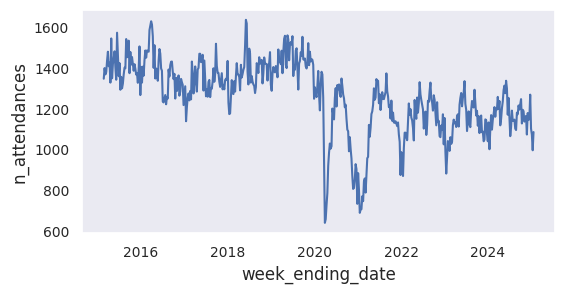

In [ ]:
fig = plt.figure(figsize=(6.1, 2.9))
handle = fig.gca()
handle.tick_params(axis='both', labelsize='small')

sns.lineplot(data=excerpt, x=excerpt.index, y='n_attendances', hue='treatment_location', ax=handle)

handle.xaxis.set_major_locator(locating)
handle.xaxis.set_major_formatter(formatting)

handle.get_legend().remove()

<br>

### PACF

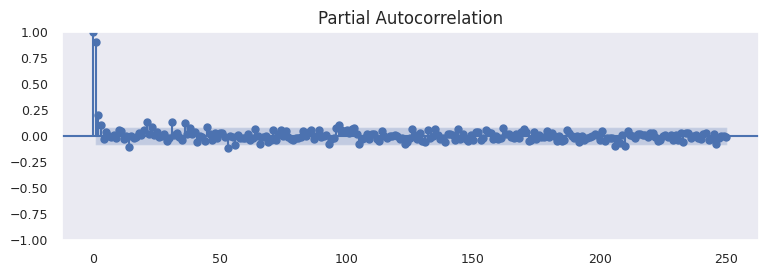

In [ ]:
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
fig, ax = plt.subplots(1, 1, figsize=(9.0, 2.7))

sa.graphics.tsa.plot_pacf(x=excerpt['n_attendances'], lags=250, ax=ax)
plt.show()

<br>

### Decomposition

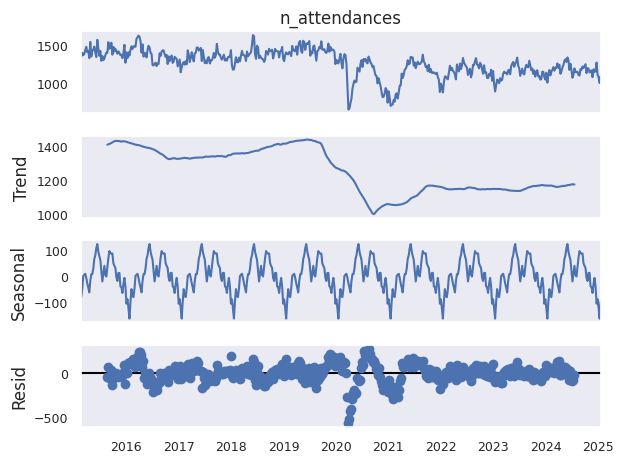

In [ ]:
graphs = stsl.seasonal_decompose(x=excerpt['n_attendances'], model='additive', period=52)
graphs.plot()
plt.show()

<br>
<br>

## Features

> ```python
excerpt['difference'] = np.concatenate((np.repeat(0, 52), np.diff(excerpt['n_attendances'], n=52)))
excerpt['n_difference'] = np.concatenate((np.repeat(0, 52), np.diff(excerpt['natural'], n=52)))
```

In [ ]:
excerpt['natural'] = np.log(excerpt['n_attendances'].to_numpy())

In [ ]:
excerpt['difference'] = excerpt['n_attendances'].diff(periods=52)
excerpt['n_difference'] = excerpt['natural'].diff(periods=52)

In [ ]:
excerpt['difference'] = excerpt['difference'].diff(periods=1)
excerpt['n_difference'] = excerpt['n_difference'].diff(periods=1)

In [ ]:
excerpt.head()

,health_board_code,treatment_location,n_attendances,n_within_4_hours,n_over_4_hours,n_over_8_hours,n_over_12_hours,natural,difference,n_difference
week_ending_date,,,,,,,,,,
2015-02-22,S08000015,A111H,1347,1115,232,31,2,7.205635,NaN,NaN
2015-03-01,S08000015,A111H,1399,1215,184,17,4,7.243513,NaN,NaN
2015-03-08,S08000015,A111H,1368,1233,135,11,0,7.221105,NaN,NaN
2015-03-15,S08000015,A111H,1380,1222,158,23,16,7.229839,NaN,NaN
2015-03-22,S08000015,A111H,1436,1202,234,23,3,7.269617,NaN,NaN


<br>
<br>

## Exclude Lost Cycle

In [ ]:
data = excerpt[53:]

In [ ]:
data.head()

,health_board_code,treatment_location,n_attendances,n_within_4_hours,n_over_4_hours,n_over_8_hours,n_over_12_hours,natural,difference,n_difference
week_ending_date,,,,,,,,,,
2016-02-28,S08000015,A111H,1483,1327,156,31,1,7.301822,-54.0,-0.039226
2016-03-06,S08000015,A111H,1479,1454,25,0,0,7.299121,27.0,0.019707
2016-03-13,S08000015,A111H,1585,1418,167,29,11,7.368340,94.0,0.060485
2016-03-20,S08000015,A111H,1607,1483,124,26,10,7.382124,-34.0,-0.025993
2016-03-27,S08000015,A111H,1628,1543,85,2,0,7.395108,-22.0,-0.016522


<br>

Illustrate

> `handle.legend(loc='right', fontsize='small')`

In [ ]:
locating = mdates.YearLocator(2)
formatting = mdates.DateFormatter('%Y')

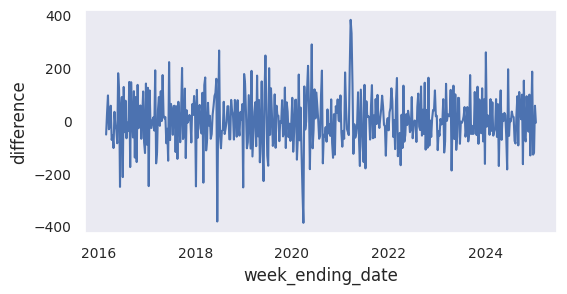

In [ ]:
fig = plt.figure(figsize=(6.1, 2.9))
handle = fig.gca()
handle.tick_params(axis='both', labelsize='small')

sns.lineplot(data=data, x=data.index, y='difference', hue='treatment_location', ax=handle)

handle.xaxis.set_major_locator(locating)
handle.xaxis.set_major_formatter(formatting)

handle.get_legend().remove()

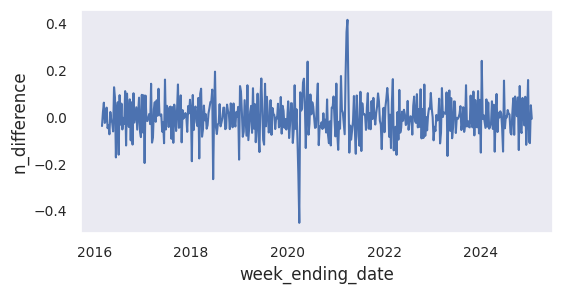

In [ ]:
fig = plt.figure(figsize=(6.1, 2.9))
handle = fig.gca()
handle.tick_params(axis='both', labelsize='small')

sns.lineplot(data=data, x=data.index, y='n_difference', hue='treatment_location', ax=handle)

handle.xaxis.set_major_locator(locating)
handle.xaxis.set_major_formatter(formatting)

handle.get_legend().remove()

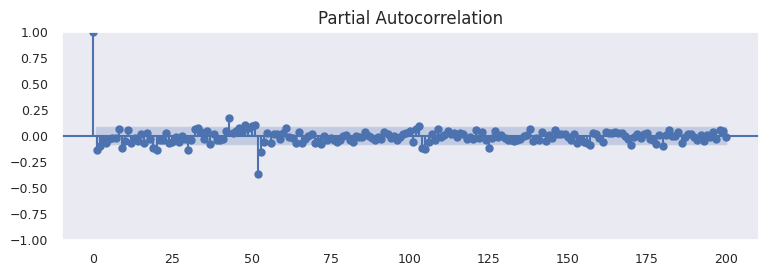

In [ ]:
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
fig, ax = plt.subplots(1, 1, figsize=(9.0, 2.7))

sa.graphics.tsa.plot_pacf(x=data['n_difference'], lags=200, ax=ax)
plt.show()

In [ ]:
data.head()

,health_board_code,treatment_location,n_attendances,n_within_4_hours,n_over_4_hours,n_over_8_hours,n_over_12_hours,natural,difference,n_difference
week_ending_date,,,,,,,,,,
2016-02-28,S08000015,A111H,1483,1327,156,31,1,7.301822,-54.0,-0.039226
2016-03-06,S08000015,A111H,1479,1454,25,0,0,7.299121,27.0,0.019707
2016-03-13,S08000015,A111H,1585,1418,167,29,11,7.368340,94.0,0.060485
2016-03-20,S08000015,A111H,1607,1483,124,26,10,7.382124,-34.0,-0.025993
2016-03-27,S08000015,A111H,1628,1543,85,2,0,7.395108,-22.0,-0.016522


In [ ]:
data[['health_board_code', 'treatment_location', 'n_difference']].to_csv(path_or_buf='natural.csv', header=True, index=True, encoding='utf-8')

In [ ]:
data['n_difference'].describe()

,n_difference
count,465.000000
mean,-0.000237
std,0.084025
min,-0.451997
25%,-0.051572
50%,-0.000684
75%,0.052223
max,0.413783


<br>
<br>

# Modelling

In [ ]:
sequence = data['n_difference'].to_numpy()

## Algorithm

In [ ]:
class Intelligence:

    def __init__(self, seq: np.ndarray) -> None:
        """

        :param seq:
        """

        self.__seq = seq

        self.__priors = {
            'coefs': {'mu': 0, 'sigma': 0.25, 'size': 53},
            'sigma': 8,
            'init': {'mu': 0.04, 'sigma': 0.1, 'size': 52},
        }

    def exc(self):
        """

        :param seq:
        """

        # Initialise the model
        with pymc.Model() as ARMODEL_:
            pass

        # Or, the original time points
        time_points = list(range(len(self.__seq)))

        # Mutable by default
        ARMODEL_.add_coord('obs_id', time_points)

        with ARMODEL_:

            # The data containers
            points = pymc.Data('points', time_points, dims='obs_id')
            observations = pymc.Data('observations', self.__seq, dims='obs_id')

            # Setting priors for each coefficient in the AR process
            coefs = pymc.Normal('coefs', mu=self.__priors['coefs']['mu'], sigma=self.__priors['coefs']['sigma'], size=self.__priors['coefs']['size'])
            sigma = pymc.HalfNormal('sigma', self.__priors['sigma'])

            # Initialisation per ...
            init = pymc.Normal.dist(
                self.__priors['init']['mu'], self.__priors['init']['sigma'], size=self.__priors['init']['size']
            )

            # Autoregressive process with p lags; lags = self.__priors['coef']['size'] - 1
            process = pymc.AR(
                'ar', coefs, sigma=sigma, init_dist=init, constant=True,
                steps=points.eval().shape[0] - (self.__priors['coefs']['size'] - 1),
                dims='obs_id')

            # Likelihood
            outcome = pymc.Normal("likelihood", mu=process, sigma=sigma, observed=observations, dims="obs_id")

            # Sampling
            details_ = pymc.sample_prior_predictive()

            details_.extend(pymc.sample(2000, random_seed=100, target_accept=0.95))
            details_.extend(pymc.sample_posterior_predictive(details_))

        return details_, ARMODEL_


In [ ]:
intelligence = Intelligence(seq=sequence)

In [ ]:
details, ARMODEL = intelligence.exc()

Output()

Output()

Output()

<br>

## Details & Model

In [ ]:
details

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [ ]:
ARMODEL

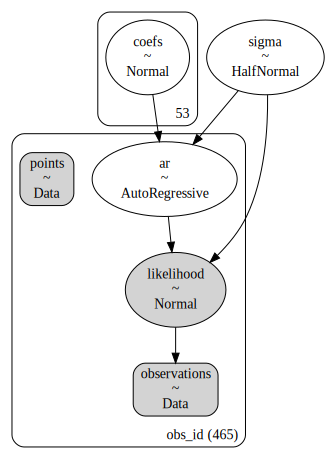

In [ ]:
pymc.model_to_graphviz(ARMODEL)

<br>

## Illustrating

array([[<Axes: title={'center': 'ar'}>,
        <Axes: title={'center': 'ar'}, xlabel='Rank (all chains)'>],
       [<Axes: title={'center': 'coefs'}>,
        <Axes: title={'center': 'coefs'}, xlabel='Rank (all chains)'>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)'>]],
      dtype=object)

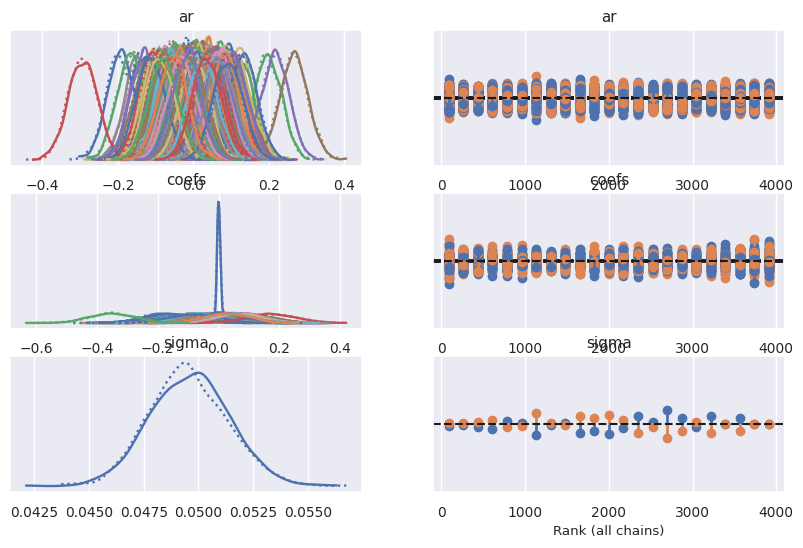

In [ ]:
sns.set(font_scale=0.8)
arviz.plot_trace(details, figsize=(10, 6), kind='rank_vlines')

<br>

## Parameter Estimates

In [ ]:
arviz.summary(details, var_names=["~ar"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coefs[0],0.001,0.007,-0.012,0.014,0.000,0.000,1500.0,1524.0,1.00
coefs[1],-0.140,0.083,-0.307,0.007,0.003,0.002,757.0,1459.0,1.00
coefs[2],-0.157,0.082,-0.307,-0.005,0.003,0.002,719.0,1605.0,1.00
coefs[3],-0.057,0.085,-0.219,0.101,0.003,0.002,752.0,1339.0,1.00
coefs[4],-0.101,0.080,-0.246,0.052,0.003,0.002,840.0,1176.0,1.00
coefs[5],-0.060,0.088,-0.217,0.111,0.003,0.002,712.0,1498.0,1.00
coefs[6],-0.036,0.085,-0.199,0.119,0.003,0.002,751.0,1651.0,1.01
coefs[7],-0.036,0.081,-0.194,0.113,0.003,0.002,715.0,1473.0,1.01
coefs[8],0.081,0.083,-0.077,0.234,0.003,0.002,707.0,1590.0,1.01
coefs[9],-0.164,0.080,-0.317,-0.016,0.003,0.002,831.0,1738.0,1.00


<br>

## Superimposing

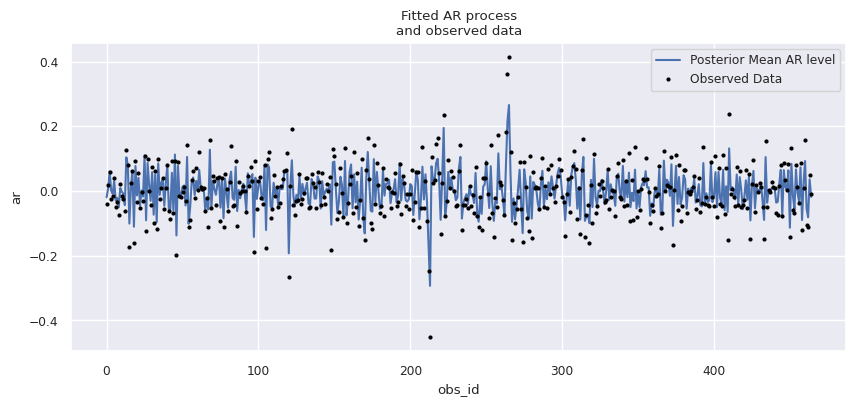

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
details.posterior.ar.mean(["chain", "draw"]).plot(ax=ax, label="Posterior Mean AR level")
ax.plot(sequence, "o", color="black", markersize=2, label="Observed Data")
ax.legend()
ax.set_title("Fitted AR process\nand observed data");

<br>

## Predicting

In [ ]:
ahead = 9
prediction_length = sequence.shape[0] + ahead

In [ ]:

with ARMODEL:

    ARMODEL.add_coords({'obs_id_ext': range(sequence.shape[0] - 52, prediction_length, 1)})
    ARMODEL.add_coords({'obs_id_original': range(sequence.shape[0], prediction_length, 1)})


In [ ]:
len(ARMODEL.coords.get('obs_id_ext'))

61

In [ ]:
len(ARMODEL.coords.get('obs_id_original'))

9

In [ ]:
with ARMODEL:

    # Conditioning on the learnt values of the autoregressive process
    # Initialising the future autoregressive process precisely at the last observed value
    # in the process, and using the special feature of the dirac delta distribution to be
    # 0 everywhere else.
    arc = pymc.AR(
        'arc',
        init_dist=pymc.DiracDelta.dist(ARMODEL.ar[..., -1]),
        rho=ARMODEL.coefs,
        sigma=ARMODEL.sigma,
        constant=True, dims='obs_id_ext')

    future = pymc.Normal('future', mu=arc[52:], sigma=ARMODEL.sigma, dims='obs_id_original')


    # Predict outcomes and probabilities via the updated values
    predictions = pymc.sample_posterior_predictive(
        details, var_names=['likelihood', 'future'], predictions=True, random_seed=100)

Output()

<br>

**Model**

In [ ]:
predictions

Inference data with groups:
	> predictions
	> predictions_constant_data

In [ ]:
ARMODEL

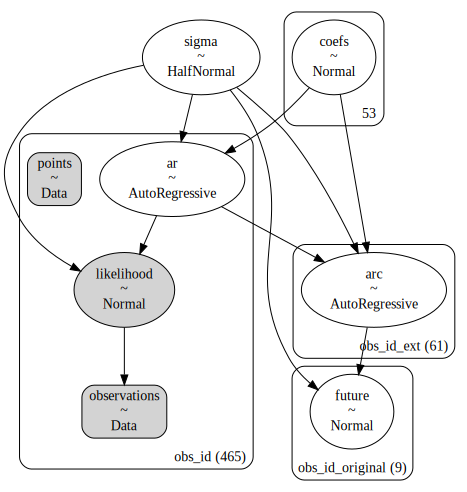

In [ ]:
pymc.model_to_graphviz(ARMODEL)

<br>

## Inspecting

> plt.subplots_adjust(wspace=0.25, hspace=0.5) $≡$ self.__fig.subplots_adjust(wspace=0.25, hspace=0.5)

In [ ]:

class Drawing:

    def __init__(self, details, predictions):
        """
        https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot_mosaic.html

        :param sequence:
        :param predictions:
        """

        self.__details = details
        self.__predictions = predictions



    def exc(self):

        plt.rc('axes', titlesize=9, labelsize=9)
        plt.rc('xtick', labelsize=9)
        plt.rc('ytick', labelsize=9)

        fig, axs = plt.subplots(1, 1, figsize=(4.0, 3.0))
        arviz.plot_ppc(self.__details, ax=axs)

        axs.legend(loc='upper right', fontsize=9)


<ipython-input-63-76c06480e962>:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs.legend(loc='upper right', fontsize=9)


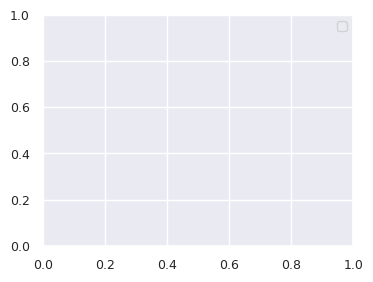

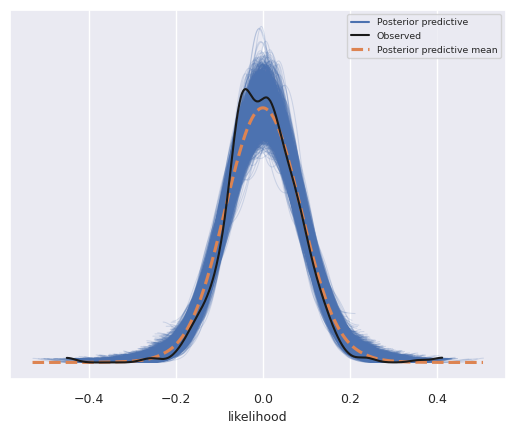

In [ ]:
Drawing(details=details, predictions=predictions).exc()

<br>
<br>

## Investigating

In [ ]:
details

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [ ]:
predictions

Inference data with groups:
	> predictions
	> predictions_constant_data

<br>
<br>

### Predictions & Likelihood

In relation to likelihood, each sample of `num_sample` will have $N$ observations, whereby $N$ is one of the dimension elements

> $likelihood_{(chain,\: draw,\: N )}$

In [ ]:
arviz.extract(data=predictions, group='predictions', num_samples=200)['likelihood'].shape

(465, 200)

In [ ]:
averages = arviz.extract(data=predictions, group='predictions', num_samples=200)['likelihood'].mean(axis=1)
averages.shape

(465,)

In [ ]:
medians = arviz.extract(data=predictions, group='predictions', num_samples=200)['likelihood'].median(axis=1)
medians.shape

(465,)

<br>
<br>

### Predictions & Future

In [ ]:
predictions['predictions']['future'].shape

(2, 2000, 9)

In [ ]:
estimates = predictions['predictions']['future'].mean(dim=['chain', 'draw'])
estimates.shape

(9,)

<br>
<br>

### Graphs Of

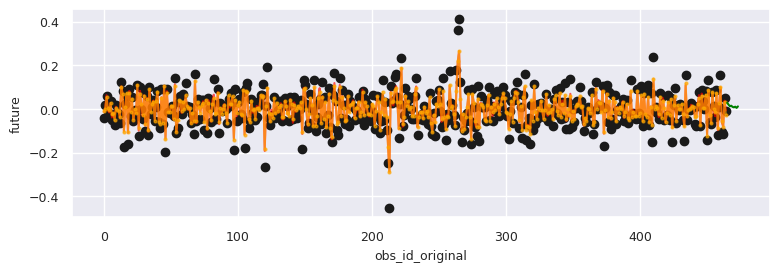

In [ ]:
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
fig, ax = plt.subplots(1, 1, figsize=(9.0, 2.7))

ax.plot(averages, color='red', alpha=0.65)
ax.plot(medians, color='orange', marker='o', markersize=2, linestyle='-', alpha=0.65)
estimates.plot(ax=ax, color='green')
ax.scatter(x=details['observed_data']['obs_id'], y=details['observed_data']['likelihood'],
           color="k", label="Observed Data")


<br>
<br>

### Boundaries: Percentiles

> cuts = np.linspace(51, 99, 100)<br>
> cuts[::-1]

**Likelihood**

In [ ]:
instances = arviz.extract(data=predictions, group='predictions', num_samples=200)['likelihood']
instances.shape

(465, 200)

In [ ]:
upper = np.percentile(a=instances, q=99, axis=1)
upper.shape

(465,)

In [ ]:
lower = np.percentile(a=instances, q=1, axis=1)
lower.shape

(465,)

<br>

**Future**

In [ ]:
forecasts = arviz.extract(data=predictions, group='predictions', num_samples=200)['future']
forecasts.shape

(9, 200)

In [ ]:
top = np.percentile(a=forecasts, q=99, axis=1)
top.shape

(9,)

In [ ]:
bottom = np.percentile(a=forecasts, q=1, axis=1)
bottom.shape

(9,)

In [ ]:
indices = forecasts.obs_id_original.values

<br>
<br>

### Graphs Of

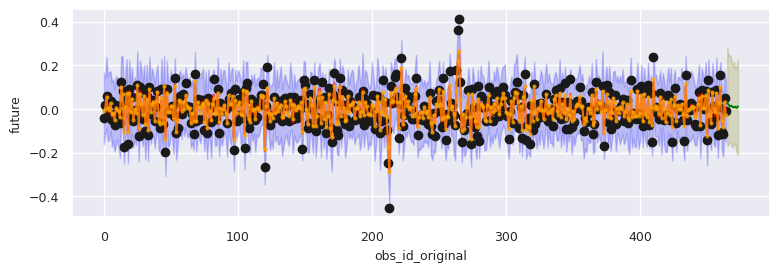

In [ ]:
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
fig, ax = plt.subplots(1, 1, figsize=(9.0, 2.7))

ax.plot(averages, color='red', alpha=0.65)
ax.plot(medians, color='orange', marker='o', markersize=2, linestyle='-', alpha=0.65)

ax.plot(upper, color='blue', linewidth=0.05, linestyle=':', alpha=0.2)
ax.plot(lower, color='blue', linewidth=0.05, linestyle=':', alpha=0.2)

ax.fill_between(predictions['predictions']['obs_id'],  lower, upper, color='blue', alpha=0.2)
ax.fill_between(indices, bottom, top, color='olive', alpha=0.2)

estimates.plot(ax=ax, color='green')
ax.scatter(x=details['observed_data']['obs_id'], y=details['observed_data']['likelihood'],
           color="k", label="Observed Data")

<br>
<br>

# Inverting